In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Keras Functional API
* Keras Functional API 는 tf.keras.Sequential API 보다 더 유연한 모델을 생성하는 방법이다
* Functional API 는 비선형 토폴로지, 공유 레이어, Multiple I/O 를 포함하는 모델을 빌드하는 방법이다
* main idea는 deep learning model은 layer에 대한 DAG(directed Acyclic Graph)라는 점이다. 
    
    (DAG; 수학, 컴퓨터 과학 분야의 용어의 하나로서 방향 순환이 없는 무한 유향 그래프이다. 즉, 무한히 수많은 꼭짓점과 간선으로 구성되며 각 간선은 하나의 꼭짓점에서 다른 꼭짓점으로 방향을 잇는데 이처럼 어떠한 꼭짓점 v에서 시작하여 끝내 다시 v로 돌아가 순환 반복되는 일정한 방향의 일련한 간선을 따라가는 방법이 없다.)


In [2]:
inputs = keras.Input(shape=(784,))
img_inputs = keras.Input(shape=(32, 32, 3))
dense = layers.Dense(64, activation="relu")
x = dense(inputs)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10, activation="sigmoid")(x)

In [3]:
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


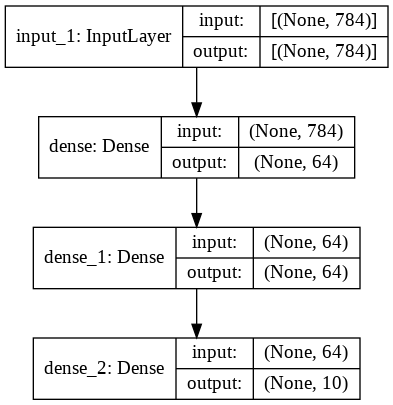

In [4]:
keras.utils.plot_model(model, show_shapes=True)

## Training, evaluation, and inference
* Model class는 fit(), evaluate() method를 제공하기 때문에 쉽게 모델을 학습시키고 평가할 수 있다.

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.2)

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/10
375/375 [==============================] - 2s 4ms/step - loss: 0.4330 - accuracy: 0.8810 - val_loss: 0.2123 - val_accuracy: 0.9382
Epoch 2/10
375/375 [==============================] - 1s 3ms/step - loss: 0.1864 - accuracy: 0.9459 - val_loss: 0.1624 - val_accuracy: 0.9540
Epoch 3/10
375/375 [==============================] - 1s 3ms/step - loss: 0.1376 - accuracy: 0.9599 - val_loss: 0.1387 - val_accuracy: 0.9593
Epoch 4/10
375/375 [==============================] - 1s 3ms/step - loss: 0.1088 - accuracy: 0.9682 - val_loss: 0.1246 - val_accuracy: 0.9637
Epoch 5/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0887 - accuracy: 0.9734 - val_loss: 0.1179 - val_accuracy: 0.9650
Epoch 6/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0742 - accuracy: 0.9776 - val_loss: 0.1046 - val_accuracy: 0.9678
Epoch 7/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0647 - 

In [6]:
test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

313/313 - 0s - loss: 0.0878 - accuracy: 0.9746
Test loss: 0.08784795552492142
Test accuracy: 0.9746000170707703


## Save and serialize
* 모델 저장 및 직렬화는 Sequential 모델과 같이 함수형 API를 사용하여 빌드된 모델에 대해 같은 방식으로 작동한다. 
* 표준 방법은 model.save()를 호출하여 전체 모델을 단일 파일로 저장하는 방법이다. 모델을 빌드한 코드를 더 이상 사용할 수 없는 경우에도 나중에 이 파일에서 같은 모델을 다시 빌드할 수 있다.

* 저장된 이 파일에는 다음이 포함됩니다.

    - model architecture
    - model weight values (that were learned during training)
    - model training config, if any (as passed to compile)
    - optimizer and its state, if any (to restart training where you left off)

In [7]:
model.save("path_to_my_model")
del model
# Recreate the exact same model purely from the file:
model = keras.models.load_model("path_to_my_model")

INFO:tensorflow:Assets written to: path_to_my_model/assets


## Use the same graph of layers to define multiple models
* Functional API에서 모델은 레이어 그래프에 입력 및 출력을 지정하여 생성된다. 즉, 단일 레이어 그래프를 사용하여 여러 모델을 생성할 수 있다.

* 아래 예에서는 같은 레이어 스택을 사용하여 두 모델을 인스턴스화한다. 
    
    (이미지 입력을 16차원 벡터로 변환하는 encoder 모델과 훈련을 위한 엔드 투 엔드 autoencoder 모델)

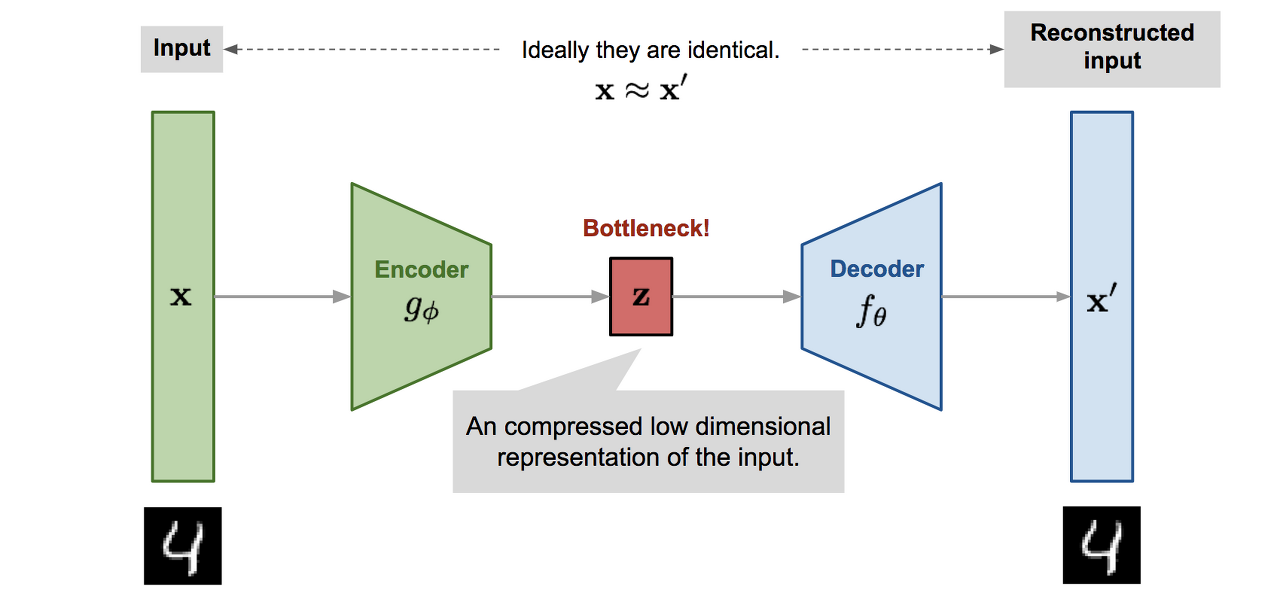

In [8]:
encoder_input = keras.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                0   

## All models are callable, just like layers
* Input 또는 또 다른 레이어의 출력에서 모델을 호출함으로써 모델을 마치 레이어와 같이 취급할 수 있다. 모델을 호출함으로써 모델의 아키텍처를 재사용할 뿐만 아니라 가중치도 재사용할 수 있다.

    (아래 코드는 인코더 모델과 디코더 모델을 만들고 두 번의 호출로 연결하여 Autoencoder 모델을 빌드하는 또 다른 방법이다.)

In [9]:
encoder_input = keras.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

decoder_input = keras.Input(shape=(16,), name="encoded_img")
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

autoencoder_input = keras.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_img (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 16)                0   

* Summary 결과에서 알 수 있듯이, 모델은 하위 모델을 포함할 수 있다(모델은 layer와 유사하게 취급).
* 모델 중첩(model nesting)의 일반적인 사용 사례는 앙상블 기법(ensembling)이다. * 아래 코드는 모델 세트를 단일 모델로 앙상블하여 예측 결과를 위해 각 모델 결과를 평균값으로 변환하는 방법이다. 

In [10]:
def get_model():
    inputs = keras.Input(shape=(128,))
    outputs = layers.Dense(1)(inputs)
    return keras.Model(inputs, outputs)


model1 = get_model()
model2 = get_model()
model3 = get_model()

inputs = keras.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
outputs = layers.average([y1, y2, y3])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
ensemble_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 1)            129         input_6[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 1)            129         input_6[0][0]                    
__________________________________________________________________________________________________
model_2 (Functional)            (None, 1)            129         input_6[0][0]                    
____________________________________________________________________________________________

## Manipulate complex graph topologies
###Models with multiple inputs and outputs
* Functional API를 사용하면 다중 입력 및 출력을 쉽게 조작할 수 있다. Sequential API로는 이를 처리할 수 없다.

* 예를 들어 우선 순위별로 사용자 지정 발급 티켓 순위를 매기고 올바른 부서로 라우팅하는 시스템을 구축하는 경우 모델에는 아래의 세 가지 입력 데이터를 받는다고 하자

1. 티켓의 제목 (텍스트 입력)
2. 티켓의 본문 (텍스트 입력)
3. 사용자가 추가 한 모든 태그 (범주 입력)

* 그리고 아래의 두 가지 출력이 있다고 하자.
1. 0과 1 사이의 우선 순위 점수 (스칼라 시그 모이 드 출력)
2. 티켓을 처리해야하는 부서 (부서 세트에 대한 softmax 출력)

* 함수형 API를 사용하여 이 모델을 몇 줄로 쉽게 빌드할 수 있다.

In [11]:
num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = keras.Input(shape=(None,), name="title")  # Variable-length sequence of ints
body_input = keras.Input(shape=(None,), name="body")  # Variable-length sequence of ints
tags_input = keras.Input(shape=(num_tags,), name="tags")  # Binary vectors of size `num_tags`

# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])

# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, name="priority")(x)
# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, name="department")(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred],
)

In [12]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
body (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     640000      title[0][0]                      
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     640000      body[0][0]                       
____________________________________________________________________________________________

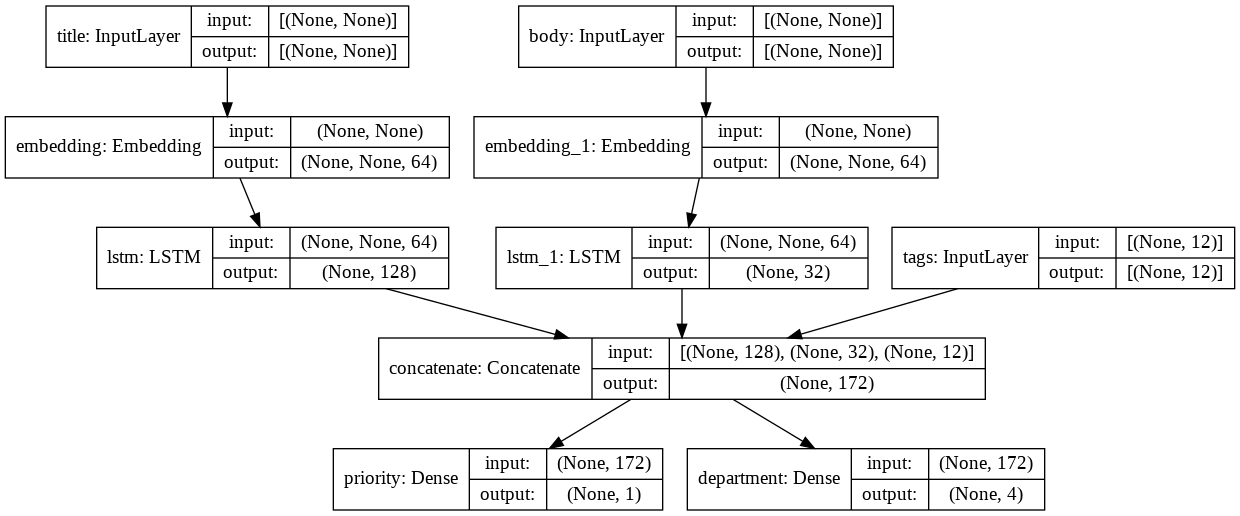

In [13]:
keras.utils.plot_model(model, show_shapes=True)

* 이 모델을 컴파일 할 때 각 출력에 서로 다른 loss function을 할당할 수 있다. 
* 또한 각 loss function에 다른 가중치를 할당하여 총 training loss에 대한 기여도를 조정하는 방법도 활용할 수 있다.

In [14]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "priority": keras.losses.BinaryCrossentropy(from_logits=True),
        "department": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights=[1.0, 0.2],
)

In [15]:
# Dummy input data
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype("float32")

# Dummy target data
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit(
    {"title": title_data, "body": body_data, "tags": tags_data},
    {"priority": priority_targets, "department": dept_targets},
    epochs=5,
    batch_size=32
)

Epoch 1/5
40/40 [==============================] - 5s 50ms/step - loss: 1.3800 - priority_loss: 0.6967 - department_loss: 3.4164
Epoch 2/5
40/40 [==============================] - 2s 47ms/step - loss: 1.4163 - priority_loss: 0.6941 - department_loss: 3.6113
Epoch 3/5
40/40 [==============================] - 2s 49ms/step - loss: 1.4009 - priority_loss: 0.6930 - department_loss: 3.5395
Epoch 4/5
40/40 [==============================] - 2s 48ms/step - loss: 1.3459 - priority_loss: 0.6865 - department_loss: 3.2970
Epoch 5/5
40/40 [==============================] - 2s 48ms/step - loss: 1.3053 - priority_loss: 0.6723 - department_loss: 3.1646


## A toy ResNet model
* 입력 및 출력이 여러 개인 모델 외에도 Functional API를 사용하면 비선형 연결 토폴로지를 쉽게 빌드할 수 있다. 이는 순차적으로 연결되지 않은 레이어가 있는 모델이며 Sequential API가 처리할 수 없는 모델이다.

* Common case 는 residual connections이다. CIFAR10을 위한 toy ResNet 모델을 아래와 같이 구성할 수 있다.

* (Resnet은 residual function, skip connection 과 같은 주요한 개념을 처음으로 제안한 모델이다. 시간이 된다면 paper review를 보도록 하자. 

    https://www.youtube.com/watch?v=671BsKl8d0E&list=PLRx0vPvlEmdADpce8aoBhNnDaaHQN1Typ&index=5

In [16]:
inputs = keras.Input(shape=(32, 32, 3), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output]) # skip connection

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output]) # skip connection

x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name="toy_resnet")
model.summary()

Model: "toy_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 30, 30, 32)   896         img[0][0]                        
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 64)   18496       conv2d_8[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 9, 9, 64)     0           conv2d_9[0][0]                   
_________________________________________________________________________________________

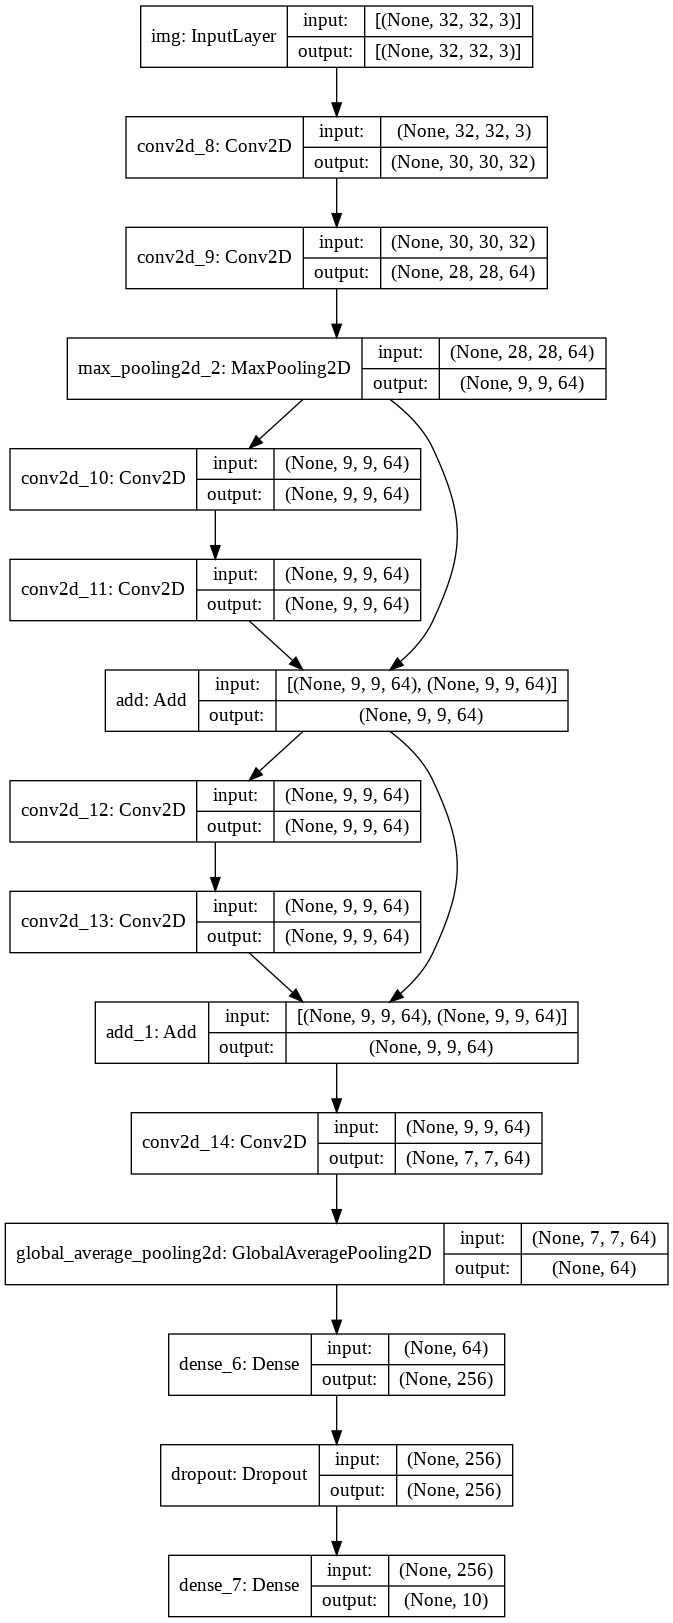

In [17]:
keras.utils.plot_model(model, show_shapes=True)

In [18]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["acc"],
)
# We restrict the data to the first 1000 samples so as to limit execution time
# on Colab. Try to train on the entire dataset until convergence!
model.fit(x_train[:1000], y_train[:1000], batch_size=64, epochs=10, validation_split=0.2)

170500096/170498071 [==============================] - 11s 0us/step
Epoch 1/10
13/13 [==============================] - 5s 347ms/step - loss: 2.3075 - acc: 0.0938 - val_loss: 2.3029 - val_acc: 0.1050
Epoch 2/10
13/13 [==============================] - 4s 331ms/step - loss: 2.2770 - acc: 0.1425 - val_loss: 2.3004 - val_acc: 0.1250
Epoch 3/10
13/13 [==============================] - 4s 328ms/step - loss: 2.1854 - acc: 0.1850 - val_loss: 2.1930 - val_acc: 0.1500
Epoch 4/10
13/13 [==============================] - 4s 335ms/step - loss: 2.1821 - acc: 0.1813 - val_loss: 2.1762 - val_acc: 0.1600
Epoch 5/10
13/13 [==============================] - 4s 337ms/step - loss: 2.1157 - acc: 0.1975 - val_loss: 2.0873 - val_acc: 0.1950
Epoch 6/10
13/13 [==============================] - 4s 338ms/step - loss: 2.0634 - acc: 0.1912 - val_loss: 1.9967 - val_acc: 0.1850
Epoch 7/10
13/13 [==============================] - 4s 338ms/step - loss: 2.0154 - acc: 0.2025 - val_loss: 2.0321 - val_acc: 0.1850
Epoch 8/

## Shared layers
* Functional API는 공유 레이어를 사용하는 모델도 빌드할 수 있다. 공유 레이어는 같은 모델에서 여러 번 재사용되는 레이어 인스턴스입니다. 레이어 그래프에서 여러 경로에 해당하는 특성을 학습합니다.

* 공유 레이어는 종종 비슷한 공간(ex: 유사한 어휘를 제공하는 두 개의 서로 다른 텍스트 조각)의 입력을 인코딩하는 데 사용된다. 공유 레이어는 서로 다른 입력 간에 정보를 공유할 수 있으며 적은 데이터에서 모델을 훈련할 수 있다. 지정된 단어가 입력 중 하나에 표시되면 공유 레이어를 통해 전달하는 모든 입력을 처리하는 데 도움이 될 수 있다.

* Functional API에서 레이어를 공유하려면, 같은 레이어 인스턴스를 여러 번 호출해야 한다. 예를 들어, 아래 예시에서는 두 가지 서로 다른 텍스트 입력 간에 공유되는 Embedding 레이어가 공유 layer이다.

In [19]:
# Embedding for 1000 unique words mapped to 128-dimensional vectors
shared_embedding = layers.Embedding(1000, 128)

# Variable-length sequence of integers
text_input_a = keras.Input(shape=(None,), dtype="int32")

# Variable-length sequence of integers
text_input_b = keras.Input(shape=(None,), dtype="int32")

# Reuse the same layer to encode both inputs
encoded_input_a = shared_embedding(text_input_a)
encoded_input_b = shared_embedding(text_input_b)

## Extract and reuse nodes in the graph of layers
* 조작하는 레이어의 그래프는 정적 데이터 구조이므로 액세스하여 검사할 수 있다. 
즉, 중간 레이어(그래프의 "노드")의 활성화에 액세스하여 다른 곳에 재사용할 수 있다는 것이고 이는 특성 추출과 같은 경우에 매우 유용하다.

* 아래 예시는 ImageNet에 가중치가 사전 훈련 된 VGG19 모델 예제이다.


In [20]:
vgg19 = tf.keras.applications.VGG19()
features_list = [layer.output for layer in vgg19.layers]

574717952/574710816 [==============================] - 5s 0us/step


In [21]:
features_list

[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_9')>,
 <KerasTensor: shape=(None, 224, 224, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, 224, 224, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, 112, 112, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, 112, 112, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, 112, 112, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, 56, 56, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv4')>,

In [22]:
feat_extraction_model = keras.Model(inputs=vgg19.input, outputs=features_list)
img = np.random.random((1, 224, 224, 3)).astype("float32")
extracted_features = feat_extraction_model(img)

In [23]:
extracted_features

[<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
 array([[[[0.42269835, 0.66022754, 0.97836363],
          [0.38423452, 0.7389096 , 0.7363909 ],
          [0.7618161 , 0.7725595 , 0.37953916],
          ...,
          [0.36747062, 0.89131784, 0.04010455],
          [0.4094521 , 0.46501207, 0.74319017],
          [0.7731943 , 0.8469524 , 0.4594848 ]],
 
         [[0.4875812 , 0.55554366, 0.7283441 ],
          [0.35940224, 0.24920665, 0.04267016],
          [0.47686306, 0.44599923, 0.4925763 ],
          ...,
          [0.8595217 , 0.00859847, 0.44164884],
          [0.7532877 , 0.7820315 , 0.19300397],
          [0.56723243, 0.24456416, 0.35374   ]],
 
         [[0.23055205, 0.44693035, 0.60551137],
          [0.58375394, 0.74288356, 0.7616952 ],
          [0.6465389 , 0.71273685, 0.53539795],
          ...,
          [0.29513913, 0.06838979, 0.55339533],
          [0.06548296, 0.86967844, 0.3617393 ],
          [0.64298457, 0.03729541, 0.51819116]],
 
         ...,
 
       

## Extend the API using custom layers
* tf.keras 는 다음과 같은 광범위한 내장 레이어를 포함합니다.

    - 컨볼루션 레이어: Conv1D, Conv2D, Conv3D, Conv2DTranspose
    - 풀링 레이어 : MaxPooling1D , MaxPooling2D , MaxPooling3D , AveragePooling1D
    - RNN 레이어 : GRU , LSTM , ConvLSTM2D
    - BatchNormalization , Dropout , Embedding 등
    
* 그러나 필요한 것을 찾지 못하면 자신의 레이어를 만들어 API를 쉽게 확장 할 수 있습니다. 모든 레이어는 Layer 클래스를 서브 클래싱하고 다음을 구현다.

* 처음부터 레이어를 만드는 방법 : https://www.tensorflow.org/guide/keras/custom_layers_and_models

* 아래의 예시는 tf.keras.layers.Dense 의 기본 구현이다.

In [24]:
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)

In [25]:
# 사용자 정의 레이어에서 직렬화를 지원하려면, 레이어 인스턴스의 constructor 인수를 반환하는 get_config 메서드를 정의한다.
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

    def get_config(self):
        return {"units": self.units}


inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)
config = model.get_config()

In [26]:
config

{'input_layers': [['input_11', 0, 0]],
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 4),
    'dtype': 'float32',
    'name': 'input_11',
    'ragged': False,
    'sparse': False},
   'inbound_nodes': [],
   'name': 'input_11'},
  {'class_name': 'CustomDense',
   'config': {'units': 10},
   'inbound_nodes': [[['input_11', 0, 0, {}]]],
   'name': 'custom_dense_1'}],
 'name': 'model_7',
 'output_layers': [['custom_dense_1', 0, 0]]}

In [27]:
new_model = keras.Model.from_config(config, custom_objects={"CustomDense": CustomDense})

## When to use the functional API
*  일반적으로, 함수형 API는 고수준의 쉽고 안전하며, 하위 클래스화되지 않은 모델에서 지원하지 않는 많은 특성을 가지고 있다.

* 모델 하위 클래스화(model subclassing)는 레이어의 방향성 비순환 그래프로 쉽게 표현할 수 없는 모델을 빌드할 때 더 큰 유연성을 제공한다. 예를 들어, 함수형 API로 Tree-RNN을 구현할 수 없고 Model을 직접 하위 클래스화해야 한다.

### Functional API strengths:
* 아래의 특성은 Sequential 모델에도 적용되지만, 하위 클래스화된 모델(데이터 구조가 아닌 파이썬 바이트 코드)에는 적용되지 않는다.

##### 장점1: super(MyClass, self).__init__(...) , def call(self, ...): 등이 없기 때문에 덜 복잡하다.



In [28]:
inputs = keras.Input(shape=(32,))
x = layers.Dense(64, activation='relu')(inputs)
outputs = layers.Dense(10)(x)
mlp = keras.Model(inputs, outputs)

In [29]:
mlp

In [30]:
# subclassed version:
class MLP(keras.Model):

  def __init__(self, **kwargs):
    super(MLP, self).__init__(**kwargs)
    self.dense_1 = layers.Dense(64, activation='relu')
    self.dense_2 = layers.Dense(10)

  def call(self, inputs):
    x = self.dense_1(inputs)
    return self.dense_2(x)

# Instantiate the model.
mlp = MLP()
mlp

In [31]:
# Necessary to create the model's state.
# The model doesn't have a state until it's called at least once.
_ = mlp(tf.zeros((1, 32)))
_

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

##### 장점2 : 연결 그래프를 정의하면서 모델을 검증한다
* Functional API에서는 입력의 특성(형상 및 dtype)이 사전에 작성된다. (Input 사용). 레이어를 호출할 때마다 레이어는 전달된 사양이 해당 가정과 일치하는지 확인하고 그렇지 않은 경우 유용한 오류 메시지를 발생시킨다.

* 이를 통해 함수형 API로 빌드할 수 있는 모든 모델이 실행된다. 수렴 관련 디버깅 이외의 모든 디버깅은 실행 중이 아니라 모델 구성 중에 정적으로 발생한다. (이것은 컴파일러에서의 유형 검사와 유사함)

##### 장점3 : 함수형 모델은 plottable and inspectable 하다.
* 모델을 그래프로 플롯하고, 이 그래프에서 중간 노드에 쉽게 액세스할 수 있다.

##### 장점4 : 함수형 모델은 직렬화 또는 복제 가능하다
* 함수형 모델은 코드가 아닌 데이터 구조이기 때문에 안전하게 직렬화할 수 있으며 단일 코드로 저장하여 원본 코드에 액세스하지 않고도 정확히 같은 모델을 다시 만들 수 있다.
* 하위 클래스화된 모델을 직렬화하려면 구현자가 모델 레벨에서 get_config() 및 from_config() 메서드를 지정해야 한다.

### Functional API weakness:
##### 단점1 : 동적 네트워크를 지원하지 않는다
* 함수형 API는 모델을 레이어의 DAG로 취급합니다. 이는 대부분의 딥 러닝 아키텍처에 해당하지만, 전부는 아니다. 예를 들어, 재귀 네트워크 또는 Tree RNN은 이 가정을 따르지 않으며 함수형 API로 구현할 수 없다.

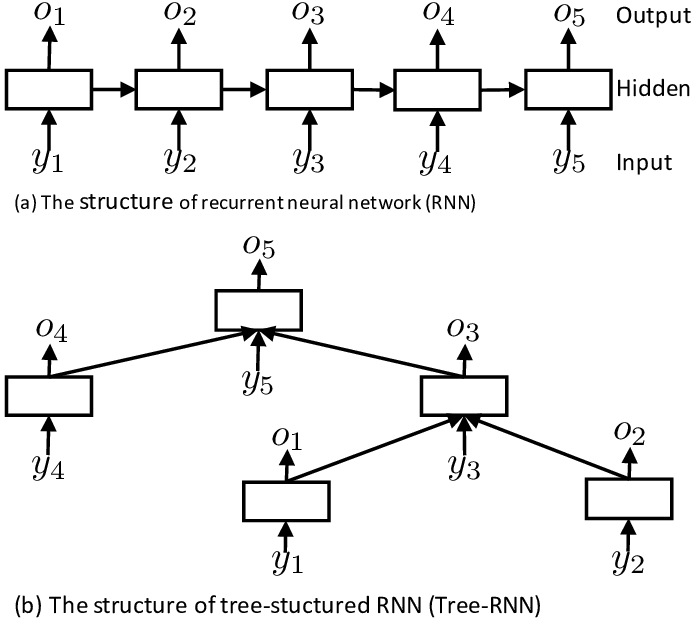

## Mix-and-match API styles
* 함수형 API 또는 Model 하위 클래스화 중에서 선택하는 문제는 반드시 하나의 모델 범주로 제한해야하는 결정이 아니다. 
* tf.keras API의 모든 모델은 Sequential 모델, Functional 모델 또는 처음부터 작성한 하위 클래스화된 모델과 관계없이 서로 상호 작용할 수 있다.
* 하위 클래스화된 모델 또는 레이어의 일부로 Functional 모델 또는 Sequential 모델을 항상 사용할 수 있다.

In [ ]:
units = 32
timesteps = 10
input_dim = 5

# Define a Functional model
inputs = keras.Input((None, units))
x = layers.GlobalAveragePooling1D()(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


class CustomRNN(layers.Layer):
    def __init__(self):
        super(CustomRNN, self).__init__()
        self.units = units
        self.projection_1 = layers.Dense(units=units, activation="tanh")
        self.projection_2 = layers.Dense(units=units, activation="tanh")
        
        self.classifier = model # Our previously-defined Functional model

    def call(self, inputs):
        outputs = []
        state = tf.zeros(shape=(inputs.shape[0], self.units))
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h = self.projection_1(x)
            y = h + self.projection_2(state)
            state = y
            outputs.append(y)
        features = tf.stack(outputs, axis=1)
        print(features.shape)
        return self.classifier(features)


rnn_model = CustomRNN()
_ = rnn_model(tf.zeros((1, timesteps, input_dim)))

(1, 10, 32)


* 또한, 사용자 정의 Layer 또는 모델에서 get_config 메서드를 구현하면 작성하는 Functional 모델은 계속 직렬화 가능하고 복제 가능하다.

In [ ]:
# example of a custom RNN, written from scratch, being used in a functional model
units = 32
timesteps = 10
input_dim = 5
batch_size = 16

class CustomRNN(layers.Layer):
    def __init__(self):
        super(CustomRNN, self).__init__()
        self.units = units
        self.projection_1 = layers.Dense(units=units, activation="tanh")
        self.projection_2 = layers.Dense(units=units, activation="tanh")
        self.classifier = layers.Dense(1)

    def call(self, inputs):
        outputs = []
        state = tf.zeros(shape=(inputs.shape[0], self.units))
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h = self.projection_1(x)
            y = h + self.projection_2(state)
            state = y
            outputs.append(y)
        features = tf.stack(outputs, axis=1)
        return self.classifier(features)


# Note that you specify a static batch size for the inputs with the `batch_shape`
# arg, because the inner computation of `CustomRNN` requires a static batch size
# (when you create the `state` zeros tensor).
inputs = keras.Input(batch_shape=(batch_size, timesteps, input_dim))
x = layers.Conv1D(32, 3)(inputs)
outputs = CustomRNN()(x)

model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(16, 10, 5)]             0         
_________________________________________________________________
conv1d (Conv1D)              (16, 8, 32)               512       
_________________________________________________________________
custom_rnn_1 (CustomRNN)     (16, 8, 1)                2145      
Total params: 2,657
Trainable params: 2,657
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rnn_model = CustomRNN()
_ = rnn_model(tf.zeros((1, 10, 5)))